# Capstone Technical notebook

Justin Chaphiv

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from functools import reduce
import datetime
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from textblob import TextBlob

# Data Pre-processing

In [58]:
#Read in the twitter data as of 05/11/2020
tweets = pd.read_excel('./data/2020.05.11_trump_tweets.xlsx')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,https://t.co/v4XFSs5NBg,2020-05-11 17:37:05,2333.0,8042.0,0.0,1.259900e+18
1,Twitter for iPhone,THE ENEMY OF THE PEOPLE. Sadly our Lamestream ...,2020-05-11 15:32:20,14860.0,47309.0,0.0,1.259869e+18
2,Twitter for iPhone,RT @Techno_Fog: Developing…The INITIAL Flynn/K...,2020-05-11 15:27:36,13349.0,0.0,1.0,1.259868e+18
3,Twitter for iPhone,RT @LeeSmithDC: Did Obama spy chief lie about ...,2020-05-11 15:27:03,5346.0,0.0,1.0,1.259868e+18
4,Twitter for iPhone,Because it was OBAMAGATE and he and Sleepy Joe...,2020-05-11 15:26:15,23900.0,68763.0,0.0,1.259867e+18


In [59]:
#all ticker data goes up until 05/11/2020
#reads in the dow jones index ticker
dow = pd.read_csv('./data/^DJI.csv')
#reads in the nasdaq composite index ticker
nasdaq = pd.read_csv('./data/^IXIC.csv')
#reads in the S&P 500 index ticker
sp500 = pd.read_csv('./data/^GSPC.csv')
#reads in the Real Estate Select Sector SPDR Fund ticker
ticks = [dow,nasdaq,sp500]
for i in ticks:
    i['diff'] = i.Open - i.Close
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume,diff
0,2009-01-20,849.640015,849.640015,804.469971,805.219971,805.219971,6375230000,44.420044
1,2009-01-21,806.770020,841.719971,804.299988,840.239990,840.239990,6467830000,-33.469970
2,2009-01-22,839.739990,839.739990,811.289978,827.500000,827.500000,5843830000,12.239990
3,2009-01-23,822.159973,838.609985,806.070007,831.950012,831.950012,5832160000,-9.790039
4,2009-01-26,832.500000,852.530029,827.690002,836.570007,836.570007,6039940000,-4.070007


In [60]:
#renames every column in each dataframe with the variable name _ feature name except for the Date column
dow.rename(lambda x: 'dow_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
nasdaq.rename(lambda x: 'nasdaq_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
sp500.rename(lambda x: 'sp500_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
#creates a list of the seperate dataframes
tickers = [dow,nasdaq,sp500]
# the reduce function from functools applys the lambda function to all DFs in the tickers list. the lamba function merges all the dfs and how argument tells the merge to keep values in even though there's not a match. 
ticker_agg = reduce(lambda left,right: pd.merge(left,right,on='Date',how='outer'), tickers)
ticker_agg['Date'] = pd.to_datetime(ticker_agg['Date'])

ticker_agg.head()

,Date,dow_open,dow_high,dow_low,dow_close,dow_adj close,dow_volume,dow_diff,nasdaq_open,nasdaq_high,...,nasdaq_adj close,nasdaq_volume,nasdaq_diff,sp500_open,sp500_high,sp500_low,sp500_close,sp500_adj close,sp500_volume,sp500_diff
0,2009-01-20,8279.629883,8291.980469,7939.930176,7949.089844,7949.089844,419200000,330.540039,1520.760010,1521.849976,...,1440.859985,1989610000,79.900025,849.640015,849.640015,804.469971,805.219971,805.219971,6375230000,44.420044
1,2009-01-21,7949.169922,8243.549805,7936.189941,8228.099609,8228.099609,410040000,-278.929687,1466.400024,1507.520020,...,1507.069946,2120080000,-40.669922,806.770020,841.719971,804.299988,840.239990,840.239990,6467830000,-33.469970
2,2009-01-22,8224.429688,8224.830078,7957.140137,8122.799805,8122.799805,420040000,101.629883,1470.849976,1492.469971,...,1465.489990,2286190000,5.359986,839.739990,839.739990,811.289978,827.500000,827.500000,5843830000,12.239990
3,2009-01-23,8108.790039,8152.589844,7909.029785,8077.560059,8077.560059,370510000,31.229980,1440.780029,1495.270020,...,1477.290039,2210840000,-36.510010,822.159973,838.609985,806.070007,831.950012,831.950012,5832160000,-9.790039
4,2009-01-26,8078.040039,8231.679688,8023.160156,8116.029785,8116.029785,316720000,-37.989746,1479.979980,1514.380005,...,1489.459961,1815400000,-9.479981,832.500000,852.530029,827.690002,836.570007,836.570007,6039940000,-4.070007


Because tweets can occur at anytime the dates need to be configured correctly in order to bring in the data. 

If Trump tweeted something on Saturday, you wouldn't see the effect of the tweet on the market until market open on monday.

So 2 days must be added to the created_at column for the tweet in order to pull in the corresponding market index data.

In [61]:

#conditionals to return the certain date in order to merge the ticker and tweet dataframes correctly

#market closes at 4:00pm and is not open on the weekends
#The day of the week with Monday=0, Sunday=6.

#set default value
tweets['Date'] = pd.to_datetime(tweets['created_at']).dt.date
#creates a list of conditions to return the correct output
conditions = [
    #tweet was created after market close and it's friday add 3 days
    (tweets['created_at'].dt.hour > 16) & (tweets['created_at'].dt.dayofweek == 4),
    #tweets was created after market close and is not friday, saturday, or sunday add 1 day
    (tweets['created_at'].dt.hour > 16) & (tweets['created_at'].dt.dayofweek < 4),
    #tweet was created on saturday add 2 days
    (tweets['created_at'].dt.dayofweek == 5),
    #tweet was created on saturday add 2 days
    (tweets['created_at'].dt.dayofweek == 6)]
#list of the outputs corresponding to the condition
choices = [tweets['Date'] + timedelta(days=3), tweets['Date'] + timedelta(days=1), tweets['Date'] + timedelta(days=2), tweets['Date'] + timedelta(days=1)]
#creates the Date column as the merge key
tweets['Date'] = np.select(conditions, choices, default=tweets['Date'])
tweets['Date'] = pd.to_datetime(tweets['Date'])

#check to see if the conditionals came out correctly
tweets.loc[tweets['created_at'].dt.dayofweek == 6].sample(10)
tweets.dtypes

source                    object
text                      object
created_at        datetime64[ns]
retweet_count            float64
favorite_count           float64
is_retweet               float64
id_str                   float64
Date              datetime64[ns]
dtype: object

In [62]:
tweets.set_index('Date')
ticker_agg.set_index('Date')

,dow_open,dow_high,dow_low,dow_close,dow_adj close,dow_volume,dow_diff,nasdaq_open,nasdaq_high,nasdaq_low,...,nasdaq_adj close,nasdaq_volume,nasdaq_diff,sp500_open,sp500_high,sp500_low,sp500_close,sp500_adj close,sp500_volume,sp500_diff
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-20,8279.629883,8291.980469,7939.930176,7949.089844,7949.089844,419200000,330.540039,1520.760010,1521.849976,1440.859985,...,1440.859985,1989610000,79.900025,849.640015,849.640015,804.469971,805.219971,805.219971,6375230000,44.420044
2009-01-21,7949.169922,8243.549805,7936.189941,8228.099609,8228.099609,410040000,-278.929687,1466.400024,1507.520020,1444.900024,...,1507.069946,2120080000,-40.669922,806.770020,841.719971,804.299988,840.239990,840.239990,6467830000,-33.469970
2009-01-22,8224.429688,8224.830078,7957.140137,8122.799805,8122.799805,420040000,101.629883,1470.849976,1492.469971,1444.079956,...,1465.489990,2286190000,5.359986,839.739990,839.739990,811.289978,827.500000,827.500000,5843830000,12.239990
2009-01-23,8108.790039,8152.589844,7909.029785,8077.560059,8077.560059,370510000,31.229980,1440.780029,1495.270020,1434.079956,...,1477.290039,2210840000,-36.510010,822.159973,838.609985,806.070007,831.950012,831.950012,5832160000,-9.790039
2009-01-26,8078.040039,8231.679688,8023.160156,8116.029785,8116.029785,316720000,-37.989746,1479.979980,1514.380005,1470.810059,...,1489.459961,1815400000,-9.479981,832.500000,852.530029,827.690002,836.570007,836.570007,6039940000,-4.070007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,23581.550781,23769.560547,23361.160156,23749.759766,23749.759766,355360000,-168.208985,8555.320313,8715.820313,8537.830078,...,8710.709961,3422150000,-155.389648,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000,-27.729980
2020-05-05,23958.880859,24169.720703,23868.910156,23883.089844,23883.089844,369710000,75.791015,8809.660156,8909.959961,8781.309570,...,8809.120117,3913360000,0.540039,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000,0.439942
2020-05-06,23978.880859,24054.589844,23661.140625,23664.640625,23664.640625,377450000,314.240234,8874.700195,8933.250000,8819.370117,...,8854.389648,3620030000,20.310547,2883.139893,2891.110107,2847.649902,2848.419922,2848.419922,4861920000,34.719971


In [63]:
tweets.rename(columns={'Date':'Date'}, inplace = True)
ticker_agg.rename(columns={'Date':'Date'}, inplace = True)
#merges the two datasets but only the the differential columns from the ticker df
df = pd.merge(tweets,ticker_agg[['dow_diff','nasdaq_diff','sp500_diff','Date']], on='Date')
#dropped these columns because i don't believe them to be useful in the model
df = df.drop(['retweet_count', 'favorite_count','is_retweet','id_str'], axis=1)
df.drop_duplicates(subset='text',inplace=True)
#df.sample(20) 
#df.mean(axis=0)

In [64]:
df.shape
#sample size of 16,646

(16646, 7)

In [65]:
#the indexes are highly correlated due to them having many of the same securities compromising their indexes
#even if they are heavily correlated. theyre the greatest measure of the overall market
df.corr()

,dow_diff,nasdaq_diff,sp500_diff
dow_diff,1.000000,0.800304,0.964249
nasdaq_diff,0.800304,1.000000,0.871338
sp500_diff,0.964249,0.871338,1.000000


Because the market indexes are a time-series data it wasn't really possible to use a NLP to predict the expected value of each index. 

My solution was to measure the change in each indexes value associated with the time of the tweet.

This allowed me to get rid of the time-series element and better quantify the effect tweets have on the indexes.

Even with this solution my model couldn't taken in 3 different target variables so I had to create one target variable.

The threshold feature is similar to the rating feature in the yelp dataset found in the NLP notebook. It's 5 stars or 1 star. from that either the tweet caused an abnormal change in the market, denoted with a "1", or saw no change, denoted with a "0".

This classification method might be a little too simple and most definetly needs improvement but was the best thing I could think of at the time.

In [66]:
df['dow_zscore'] = abs((df['dow_diff'] - df['dow_diff'].mean())/df['dow_diff'].std(ddof=0))
df['nasdaq_zscore'] = abs((df['nasdaq_diff'] - df['nasdaq_diff'].mean())/df['nasdaq_diff'].std(ddof=0))
df['sp500_zscore'] = abs((df['sp500_diff'] - df['sp500_diff'].mean())/df['sp500_diff'].std(ddof=0))
#I believed that due to each of the indexes have high correlation with one another. You could expect them to experience the same level of change and should have similar z-scores in each instances. 
#With this reasoning i added the absolute values of each z-score and if the total passed a threshold it was marked as abnormal
df['total_zscore'] = sum([df['dow_zscore'],df['nasdaq_zscore'],df['sp500_zscore']]) 
df['text'] = df['text'].str.lower()
df.sample(20)

,source,text,created_at,Date,dow_diff,nasdaq_diff,sp500_diff,dow_zscore,nasdaq_zscore,sp500_zscore,total_zscore
13247,Twitter for iPhone,last night in minnesota was incredible. what a...,2018-06-21 12:50:56,2018-06-21,177.511719,87.349610,19.520019,0.629044,1.030264,0.625744,2.285052
13931,Twitter for iPhone,while security spending was somewhat more than...,2018-04-08 00:03:23,2018-04-09,58.419922,21.110351,4.020020,0.193537,0.272833,0.107693,0.574063
10838,Twitter for iPhone,rt @kenpaxtontx: voter fraud alert: the @txsec...,2019-01-27 15:28:22,2019-01-28,68.759766,-10.670410,1.119873,0.231349,0.090572,0.010763,0.332684
10814,Twitter for iPhone,....large protests all across venezuela today ...,2019-01-30 21:58:38,2019-01-31,-45.189453,-73.570312,-18.610108,0.185353,0.809818,0.648666,1.643836
2729,Twitter for iPhone,rt @rita_katz: 5)as i said yesterday all but c...,2020-02-01 14:04:51,2020-02-03,-80.160156,-82.680664,-13.260010,0.313237,0.913993,0.469851,1.697081
9374,Twitter for iPhone,thank you @foxandfriends great show this morni...,2019-05-13 10:52:30,2019-05-13,243.070313,73.049804,28.319824,0.868785,0.866749,0.919857,2.655392
3747,Twitter for iPhone,rt @danscavino: #merrychristmas #kag🇺🇸https://...,2019-12-26 11:59:08,2019-12-26,-81.929687,-52.179687,-12.709961,0.319708,0.565221,0.451467,1.336397
14551,Twitter for iPhone,rt @speakerryan: for individuals and families ...,2017-12-16 03:09:06,2017-12-18,-52.638672,-14.359864,-4.239990,0.212594,0.132760,0.168378,0.513732
6051,Twitter for iPhone,i’m fighting for the american people but the d...,2019-10-16 22:19:13,2019-10-17,6.500000,20.060058,2.820069,0.003671,0.260823,0.067588,0.332082
5829,Twitter for iPhone,....order a couple of months ago saying that a...,2019-10-23 12:29:22,2019-10-23,1.291015,-29.549805,-10.510010,0.015378,0.306454,0.377939,0.699771


In [67]:
def z_threshold(total_zscore):
    if total_zscore >= 2.5:
        return 1
    else:
        return 0
df['threshold'] = df['total_zscore'].apply(z_threshold)
#a threshold of 1 means there was a siginifcant change in the market. a threshold of 0 means there was not a significant change in the market

# NLP and Tests

In [68]:
#function from lesson plan to measure the accuracy of each model
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print(('Features: ', X_train_dtm.shape[1]))
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print(('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)))

## Vectorization Only

In [69]:
X = df['text']
y = df['threshold']

In [70]:
#split the data into 75% training and 25% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
#initilize Vectorization
vect = CountVectorizer()

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

X_train_dtm.shape
#19,798 features

(12484, 19798)

In [71]:
#intiate the naive bayes model
nb = MultinomialNB()
#fitting the data
nb.fit(X_train_dtm, y_train)
#applying the prediction
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy. accuracy is low but will tune to find better parameters
tokenize_test(vect)

('Features: ', 19798)
('Accuracy: ', 0.7991350312349832)


In [72]:
#compare baseline accuracy. model does slightly better 
y_test.value_counts(normalize=True)

0    0.785199
1    0.214801
Name: threshold, dtype: float64

In [73]:
#Comparison of the model to the dataset itself
X_dtm = vect.transform(X)
df['pred'] = nb.predict(X_dtm)
print("Predictions:")
print(df['pred'].value_counts(normalize=True))
print("Actuals:")
print(df['threshold'].value_counts(normalize=True))
#with just vectorization the curent model is over predicting 0s

Predictions:
0    0.881653
1    0.118347
Name: pred, dtype: float64
Actuals:
0    0.78193
1    0.21807
Name: threshold, dtype: float64


## Vectorization with N-grams and Stopwords

In [74]:
X = df['text']
y = df['threshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [75]:
vect = CountVectorizer(stop_words='english', ngram_range=(1,1),max_features=100000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)


tokenize_test(vect)
y_test.value_counts(normalize=True)

('Features: ', 19514)
('Accuracy: ', 0.8032196059586737)


0    0.785199
1    0.214801
Name: threshold, dtype: float64

In [76]:
print('1-gram only')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)


print('1-grams and 2-grams')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

print('1-grams only and 3-grams')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 3), max_features=100000)
tokenize_test(vect)

print('1-grams only, and 4-grams')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 4), max_features=100000)
tokenize_test(vect)

print('1-grams only, and 5-grams')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 5), max_features=100000)
tokenize_test(vect)

#1 and 2 grams resulted in my highest accuracy and the model will use that

1-gram only
('Features: ', 19514)
('Accuracy: ', 0.8032196059586737)
1-grams and 2-grams
('Features: ', 100000)
('Accuracy: ', 0.8065833733781835)
1-grams only and 3-grams
('Features: ', 100000)
('Accuracy: ', 0.8044209514656415)
1-grams only, and 4-grams
('Features: ', 100000)
('Accuracy: ', 0.8044209514656415)
1-grams only, and 5-grams
('Features: ', 100000)
('Accuracy: ', 0.8034598750600673)


In [79]:
X = df['text']
y = df['threshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

,source,text,created_at,Date,dow_diff,nasdaq_diff,sp500_diff,dow_zscore,nasdaq_zscore,sp500_zscore,total_zscore,threshold,pred
0,Twitter for iPhone,....must read for anybody looking for u.s. sec...,2020-05-08 16:58:27,2020-05-08,-223.5,-64.430665,-20.969971,0.837417,0.705308,0.727539,2.270264,0,0
1,Twitter for iPhone,retired ice director tom homan knows more abou...,2020-05-08 16:58:26,2020-05-08,-223.5,-64.430665,-20.969971,0.837417,0.705308,0.727539,2.270264,0,0
2,Twitter for iPhone,drain the swamp!,2020-05-08 11:29:39,2020-05-08,-223.5,-64.430665,-20.969971,0.837417,0.705308,0.727539,2.270264,0,0
3,Twitter for iPhone,yesterday was a big day for justice in the usa...,2020-05-08 11:18:13,2020-05-08,-223.5,-64.430665,-20.969971,0.837417,0.705308,0.727539,2.270264,0,0
4,Twitter for iPhone,i will be interviewed on @foxandfriends at 8:0...,2020-05-08 11:11:43,2020-05-08,-223.5,-64.430665,-20.969971,0.837417,0.705308,0.727539,2.270264,0,0


In [87]:
#adding the stop_word parameter causes the model accuracy to increase
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2), max_features=100000)
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
tokenize_test(vect)
X_dtm = vect.transform(X)
df['pred'] = nb.predict(X_dtm)
#print("Predictions:")
#print(df['pred'].value_counts(normalize=True))
#print("Actuals:")
#print(df['threshold'].value_counts(normalize=True))

('Features: ', 100000)
('Accuracy: ', 0.8065833733781835)


ValueError: dimension mismatch

In [56]:
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2), max_features=100000)
X_dtm = vect.transform(X)
df['pred'] = nb.predict(X_dtm)

NotFittedError: Vocabulary not fitted or provided

In [49]:
#adding a df factor dropped the accuracy of the model
print('min_df = 3')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=3, max_features=100000)
tokenize_test(vect)

print('min_df = 2')
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2, max_features=100000)
tokenize_test(vect)

min_df = 3
('Features: ', 12750)
('Accuracy: ', 0.7844786160499759)
min_df = 2
('Features: ', 25406)
('Accuracy: ', 0.8020182604517059)


## Lemmas

In [86]:
def split_into_lemmas(text):
    text = text.lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]


In [85]:
#tried making use of Lemmas but it dropped my model accuracy so it was not utilized
X = df['text']
y = df['threshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer(analyzer=split_into_lemmas, decode_error='replace',stop_words='english',ngram_range=(1, 2),min_df=3, max_features=100000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

tokenize_test(vect)

X_dtm = vect.transform(X)
df['pred'] = nb.predict(X_dtm)
print(df['pred'].value_counts(normalize=True))
print(df['threshold'].value_counts(normalize=True))

('Features: ', 6174)
('Accuracy: ', 0.7815953868332532)
0    0.844647
1    0.155353
Name: pred, dtype: float64
0    0.78193
1    0.21807
Name: threshold, dtype: float64


Conclusion:

A vectoraization model with the use of stop-words, N-gram of 2, a maximum of 100,000 features gives us our best model with an accuracy of 80.6%

# Final Model Test

In [ ]:
#model of choice
X = df['text']
y = df['threshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2), max_features=100000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
tokenize_test(vect)

## Data pre-processing (for new data)

In [ ]:
dow = pd.read_csv('./data/2020.05.12^DJI.csv')
#reads in the nasdaq composite index ticker
nasdaq = pd.read_csv('./data/2020.05.12^IXIC.csv')
#reads in the S&P 500 index ticker
sp500 = pd.read_csv('./data/2020.05.12^GSPC.csv')
#reads in the Real Estate Select Sector SPDR Fund ticker
ticks = [dow,nasdaq,sp500]
for i in ticks:
    i['diff'] = i.Open - i.Close
    
tweets = pd.read_excel('./data/2020.05.12_trump_tweets.xlsx')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [ ]:

#renames every column in each dataframe with the variable name _ feature name except for the Date column
dow.rename(lambda x: 'dow_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
nasdaq.rename(lambda x: 'nasdaq_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
sp500.rename(lambda x: 'sp500_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
#creates a list of the seperate dataframes
tickers = [dow,nasdaq,sp500]
# the reduce function from functools applys the lambda function to all new_dfs in the tickers list. the lamba function merges all the new_dfs and how argument tells the merge to keep values in even though there's not a match. 
ticker_agg = reduce(lambda left,right: pd.merge(left,right,on='Date',how='outer'), tickers)
ticker_agg['Date'] = pd.to_datetime(ticker_agg['Date'])

tweets['Date'] = pd.to_datetime(tweets['created_at']).dt.date
#creates a list of conditions to return the correct output


In [ ]:
conditions = [
    #tweet was created after market close and it's friday add 3 days
    (tweets['created_at'].dt.hour > 16) & (tweets['created_at'].dt.dayofweek == 4),
    #tweets was created after market close and is not friday, saturday, or sunday add 1 day
    (tweets['created_at'].dt.hour > 16) & (tweets['created_at'].dt.dayofweek < 4),
    #tweet was created on saturday add 2 days
    (tweets['created_at'].dt.dayofweek == 5),
    #tweet was created on saturday add 2 days
    (tweets['created_at'].dt.dayofweek == 6)]
#list of the outputs corresponding the the condition
choices = [tweets['Date'] + timedelta(days=3), tweets['Date'] + timedelta(days=1), tweets['Date'] + timedelta(days=2), tweets['Date'] + timedelta(days=1)]

In [ ]:
tweets['Date'] = np.select(conditions, choices, default=tweets['Date'])
tweets['Date'] = pd.to_datetime(tweets['Date'])
tweets.set_index('Date')
ticker_agg.set_index('Date')
tweets.rename(columns={'Date':'Date'}, inplace = True)
ticker_agg.rename(columns={'Date':'Date'}, inplace = True)
new_df = pd.merge(tweets,ticker_agg[['dow_diff','nasdaq_diff','sp500_diff','Date']], on='Date')
new_df = new_df.drop(['retweet_count', 'favorite_count','is_retweet','id_str'], axis=1)
new_df.drop_duplicates(subset='text',inplace=True)
new_df['dow_zscore'] = abs((new_df['dow_diff'] - new_df['dow_diff'].mean())/new_df['dow_diff'].std(ddof=0))
new_df['nasdaq_zscore'] = abs((new_df['nasdaq_diff'] - new_df['nasdaq_diff'].mean())/new_df['nasdaq_diff'].std(ddof=0))
new_df['sp500_zscore'] = abs((new_df['sp500_diff'] - new_df['sp500_diff'].mean())/new_df['sp500_diff'].std(ddof=0))
new_df['total_zscore'] = sum([new_df['dow_zscore'],new_df['nasdaq_zscore'],new_df['sp500_zscore']]) 
new_df['text'] = new_df['text'].str.lower()

In [ ]:
new_df['threshold'] = new_df['total_zscore'].apply(z_threshold)
new_df.sample(20)

In [ ]:
new_df.shape

## Application of the Final Model on New Data

In [ ]:
X = new_df['text']
y = new_df['threshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2), max_features=100000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
tokenize_test(vect)

In [ ]:
y_test.value_counts(normalize=True)

In [ ]:
vect = CountVectorizer(stop_words='english',ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)
X_dtm = vect.transform(X)
new_df['pred'] = nb.predict(X_dtm)
print(new_df['pred'].value_counts(normalize=True))
print(new_df['threshold'].value_counts(normalize=True))
#accuracy did drop with the new dataset

In [ ]:
new_df['check'] = np.where((new_df['threshold'] == new_df['pred']),1,0)
#df.loc[df['pred']==1].sample(30)
print('prediction accuracy:')
print(df['check'].sum()/len(df))
#the models ability to accurately predict values is still high

# Conclusion

<b>Findings: </b>

-the model is accurately able predict tweets that are associated with abnormal gains/losses in the indexes with 87.4% accuracy.

-Even with this level of accuracy, I don't believe there to be enough evidence to say that Trump's tweets have a lasting effect on the overall market.

-I think there are other factors involved in the abnormal changes within the market such as COVID-19.

-Even if isn't a direct causation between Trump's tweets and the market indexes. It's interesting to see the effect of the President's liberal use of Twitter on the financial markets.

Is it good that we have a President so willing to give more transparency into their policy making/thought process or does it do more harm?
I would love to try to analyze the tweets even further and their effects on other things such as policy making, social-economic factors, sentiment of citizens, etc.

<br> </br>

<b>Improvements for next time </b>

-Maybe a scale for the threshold would've been better instead of it being binary so you could measure the magnitude of the possible change

-better removal of foreign text in the tweets. emojis and mispellings were still being added into the feature list

-I think the approach of which to measure the effect of a Trump tweet could be improved by isolating on other economic factors or isolate onto certain corporations. 

-maybe other methodologies or regression methods that could've been used to make better models but I focused on the NLP ones


# Slides

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">...does not include the Fake Washington Post, which is used as a “lobbyist” and should so REGISTER. If the P.O. “increased its parcel rates, Amazon’s shipping costs would rise by $2.6 Billion.” This Post Office scam must stop. Amazon must pay real costs (and taxes) now!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/980065419632566272?ref_src=twsrc%5Etfw">March 31, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

(array([1350., 1375., 1400., 1425., 1450., 1475., 1500., 1525., 1550.,
        1575.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 0 Axes>

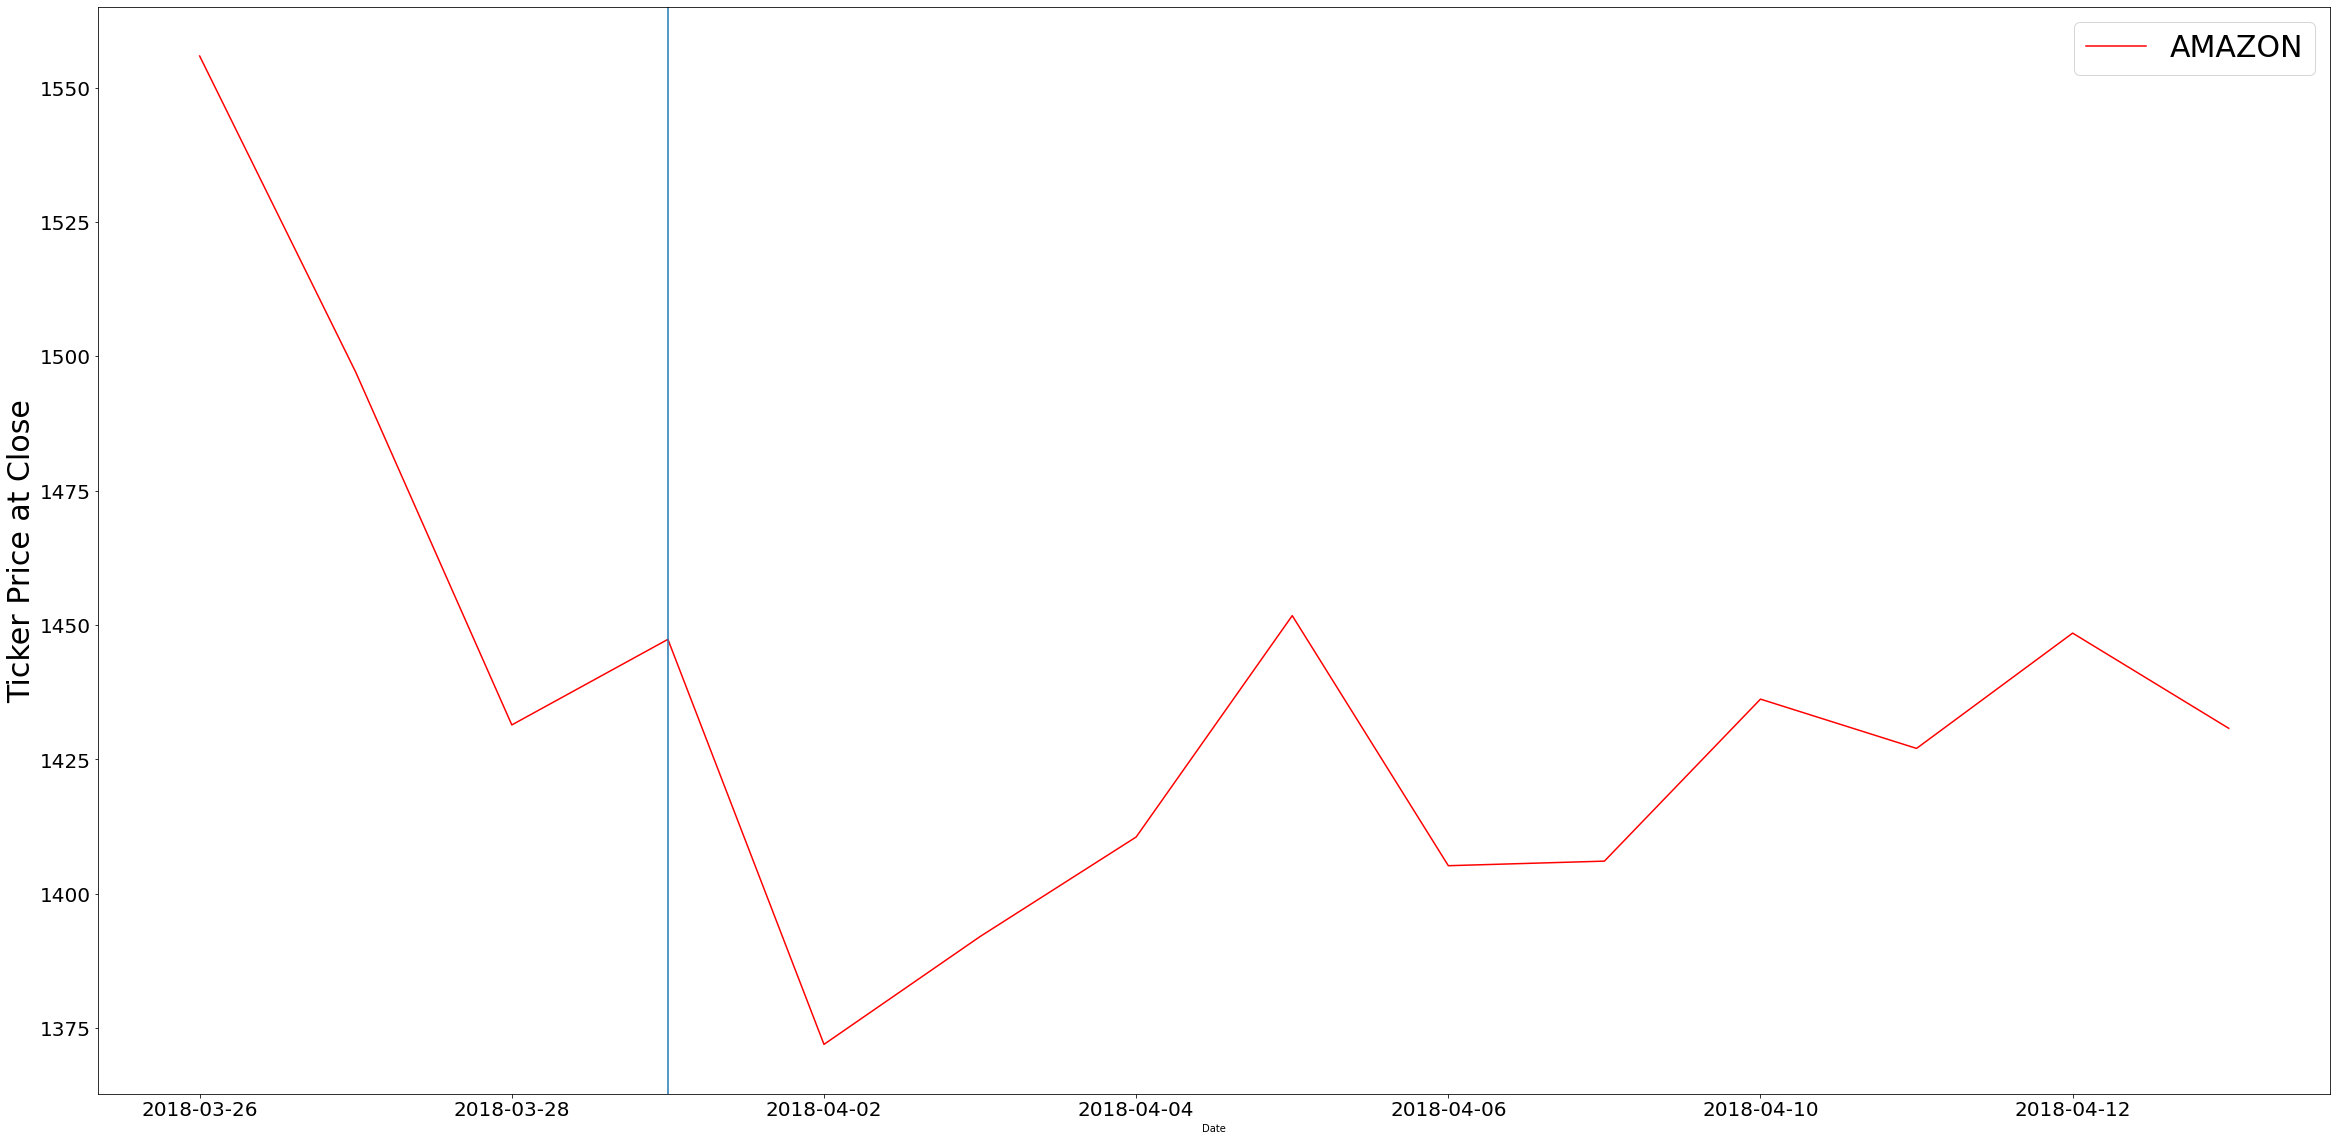

In [3]:
#slide 3
from matplotlib import pyplot as plt  
amzn = pd.read_csv('./data/AMZN.csv')
fig = plt.figure()
amzn.plot(kind='line',x='Date',y='Close',figsize=(40,20),color='r', fontsize=15)
plt.legend(["AMAZON"],fontsize=30)
plt.axvline(3);
plt.xticks(fontsize=20)
plt.ylabel('Ticker Price at Close', fontsize=30)
plt.yticks(fontsize=20)

In [4]:
#Slide 6
df[['text','created_at','dow_diff','sp500_diff','nasdaq_diff','threshold']].sample(5)

NameError: name 'df' is not defined